In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import yaml

inputNodeColor = 'red'
detectNodeColor = 'orange'
NodeColor = 'skyblue'
backboneEdgeColor = 'red'
headEdgeColor = 'yellow'
def DrawNetwork(cfg):
    G = nx.DiGraph()
    with open(cfg, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
        backbone_layers = data['backbone']
        head_layers = data['head']

    nodes = []
    G.add_node('input', layer_type='input', args=[],path = 'input', repeats=1)
    for i, (fromNode, repeats, module, args) in enumerate(backbone_layers):
        nodeName = f'{module} \n{len(nodes)}'
        if i == 0:
            from_node = 'input'
        else:
            from_node = list(nodes)[fromNode]
        G.add_node(nodeName, layer_type=module, args=args, path = f'backbone', repeats=repeats)
        nodes += [nodeName]
        G.add_edge(from_node, nodeName)

    for i, (fromNode, repeats, module, args) in enumerate(head_layers):
        if type(fromNode) != list:
            from_node = list(nodes)[fromNode]
            nodeName = f'{module} \n{len(nodes)}'
            G.add_node(nodeName, layer_type=module, args=args, path = f'head', repeats=repeats)
            nodes += [nodeName]
            G.add_edge(from_node, nodeName)
        else:
            if module != 'Detect':
                nodeName = f'{module} \n{len(nodes)}'
                G.add_node(nodeName, layer_type=module, args=args, path = f'head', repeats=repeats)
                nodes += [nodeName]
                for from_node in fromNode:
                    if from_node < 0:
                        from_node = list(nodes)[from_node-1]
                    else:
                        from_node = list(nodes)[from_node]
                    G.add_edge(from_node, nodeName)
            else:
                for i,(from_node) in enumerate(fromNode):
                    nodeName = f'Detect'
                    if i == 0:
                        nodeName = f'Detect\n(small)'
                    if i == 1:
                        nodeName = f'Detect\n(medium)'
                    if i == 2:
                        nodeName = f'Detect\n(large)'
                    G.add_node(nodeName, layer_type=module, args=args, path = f'Detect', repeats=repeats)
                    nodes += [nodeName]
                    G.add_edge(list(nodes)[from_node], nodeName)

    pos = nx.bfs_layout(G, 'input',align='vertical')
    plt.figure(figsize=(16*1.5, 10*1.5))
    node_colors = []
    for node in G.nodes():
        if G.nodes[node]["path"] == 'input':
            node_colors.append(inputNodeColor)
        elif G.nodes[node]["path"] == 'Detect':
            node_colors.append(detectNodeColor)
        else:
            node_colors.append(NodeColor)

    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=1000,
                     edge_color='gray', linewidths=12, font_size=14)


    for (u, v, d) in G.edges(data=True):
        if G.nodes[v]["path"] == 'backbone':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=3, arrowstyle='-|>', edge_color=backboneEdgeColor,arrowsize=30)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=3, arrowstyle='-|>',edge_color=headEdgeColor,arrowsize=30)
        if G.nodes[u]["path"] != 'input' and G.nodes[v]["path"] != 'input':
            nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{nodes.index(u)}->{nodes.index(v)}'}, font_size=12)


    legend_elements = [
        plt.Circle((0, 0), 1, color=NodeColor, label='Module'),
                       plt.Line2D([0], [0], color=backboneEdgeColor, lw=4, label='Backbone'),
                       plt.Line2D([0], [0], color=headEdgeColor, lw=4, label='Head'),
        plt.Circle((0, 0), 1, color=detectNodeColor, label='Detect')
    ]

    legend1 = plt.legend(handles=legend_elements, loc='lower right', title='Legend', fontsize='large',title_fontsize='large')

    detail_legent = []
    for i,(node) in enumerate(G.nodes()):
        if G.nodes[node]["path"] != 'input' and G.nodes[node]["path"] != 'Detect':
            detail_legent.append(plt.Circle((0, 0), 1, color=node_colors[i], label=f'{G.nodes[node]["layer_type"]}_{i-1} x{G.nodes[node]["repeats"]}\n {G.nodes[node]["args"]}'))
        else:
            detail_legent.append(plt.Circle((0, 0), 1, color=node_colors[i], label=f'{node}'))

    legend2 = plt.legend(handles=detail_legent, loc='lower left', title='Module Types [module,repeats,args]', fontsize='large', ncol=3,title_fontsize='large')

    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)

    plt.title('YOLOv11 Model Architecture')
    plt.show()

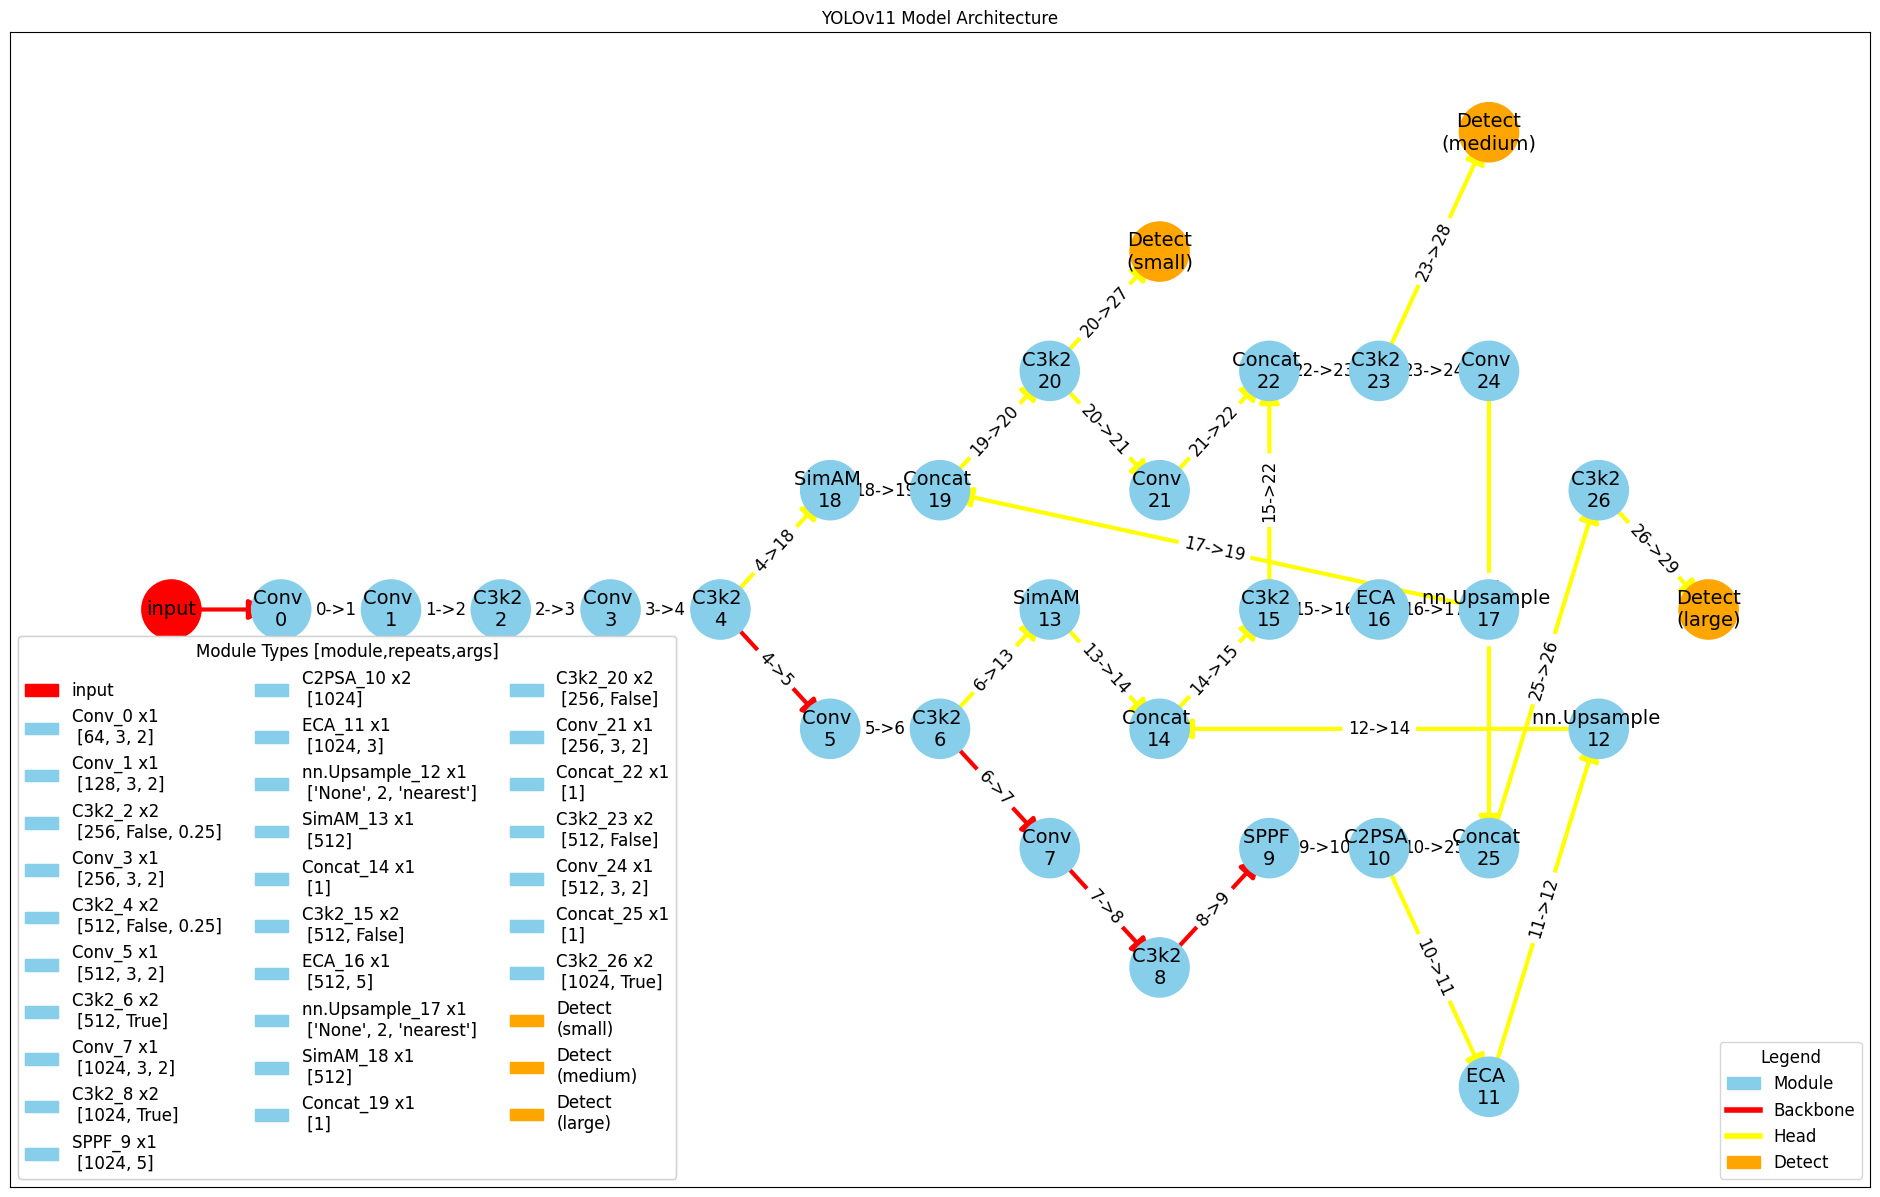

In [21]:
DrawNetwork("ultralytics/cfg/models/11/yolo11n-MAFPN.yaml")

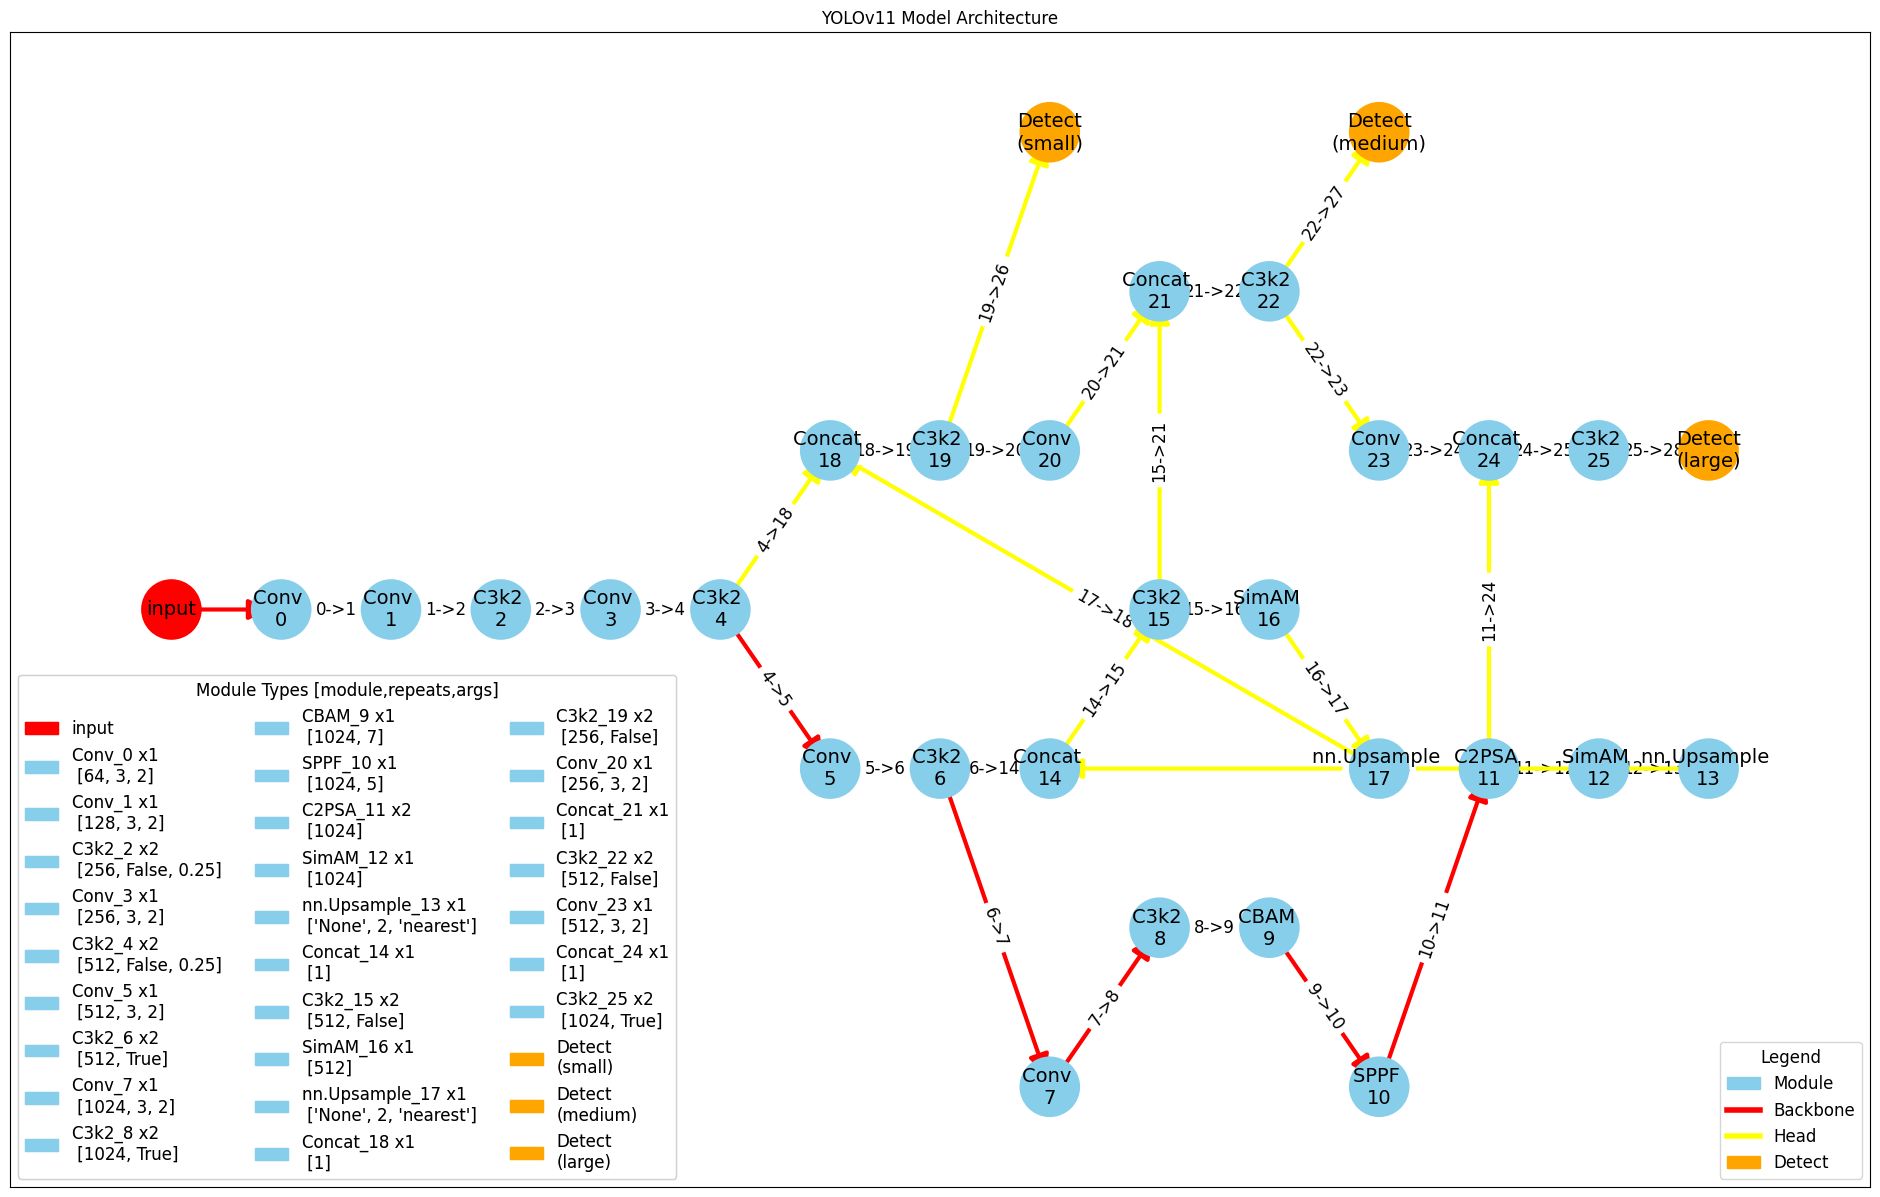

In [20]:
DrawNetwork("ultralytics/cfg/models/11/yolo11n-SimAM.yaml")